In [1]:
from __future__ import division
import hoomd
import hoomd.md
import numpy
import ex_render
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Define a simulation context
sim1 = hoomd.context.initialize("");
# Create the snapshot
snapshot = hoomd.data.make_snapshot(N=1,
                                    box=hoomd.data.boxdim(Lx = 10.8, 
                                                          Ly = 1.2, 
                                                          Lz = 1.2),
                                    particle_types=['R']);
#Assign the positions of the chain
snapshot.particles.position[:] = [(0,0,0)];
snapshot.replicate(2,18,18);

#-----
system = hoomd.init.read_snapshot(snapshot);

system.particles.types.add('A');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies()


#-----Define the potential energy

nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')
lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

#-----Define pressure as a value that varies over time.

pressure = hoomd.variant.linear_interp(points = [(0, 1.0), (1e4, 10.0)], zero = 'now')


#-----Select an NPT integrator

hoomd.md.integrate.mode_standard(dt=0.005);
rigid = hoomd.group.rigid_center();
hoomd.md.integrate.npt(group = rigid, kT = 1.0, tau = 0.5, tauP = 1.0, P = pressure);
hoomd.dump.gsd("trajectory4.gsd",
               period=2e3,
               group=hoomd.group.all(),
               overwrite=True);  

#-----Write output

log = hoomd.analyze.log(filename="log-output.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure'],
                         period=100,
                         overwrite=True);

HOOMD-blue 2.6.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 05/29/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 648 particles
notice(2): constrain.rigid(): Creating 648 rigid bodies (adding 5184 particles)
notice(2): Group "rigid_center" created containing 648 particles


In [4]:
with sim1:
    hoomd.run(1e4)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 5832
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **


*Warning*: Integrator #0: Anisotropic integration requested, but no rotational degrees of freedom found for its group


Time 00:00:49 | Step 4430 / 10000 | TPS 442.939 | ETA 00:00:12
Time 00:00:59 | Step 8861 / 10000 | TPS 443.071 | ETA 00:00:02
Time 00:01:01 | Step 10000 / 10000 | TPS 447.39 | ETA 00:00:00
Average TPS: 443.426
---------
-- Neighborlist stats:
313 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 16 / n_neigh_avg: 7.66667
shortest rebuild period: 3
-- Cell list stats:
Dimension: 12, 12, 12
n_min    : 1 / n_max: 8 / n_avg: 3.375
** run complete **


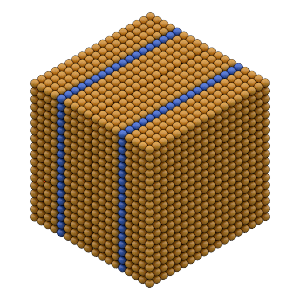

In [5]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

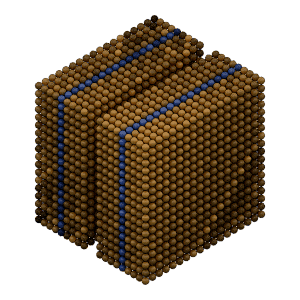

In [7]:
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory4.gsd');